# 1.Importing Dependencies 

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from pprint import pprint
from sklearn.preprocessing import StandardScaler
from pyopt1.client import PriceHistory
from fake_useragent import UserAgent

In [2]:
pd.reset_option("all")

# 2.Getting Data 

In [3]:
symbols = ['AAPL', 'MSFT', 'SQ']
number_of_symbols = len(symbols)

In [5]:
if not pathlib.Path(r'C:\Users\manav\Python_Jupyter\ML Projects\Finance Monte Carlo Simulations\Attempt 1\data\stock_data.csv').exists():
    
    # Initialize the client.
    price_history_client = PriceHistory(
        symbols=['AAPL','MSFT','SQ'],
        user_agent=UserAgent().edge
    )

    # Dump it to a CSV file.
    price_history_client.price_data_frame.to_csv(
        r'C:\Users\manav\Python_Jupyter\ML Projects\Finance Monte Carlo Simulations\Attempt 1\data\stock_data.csv',
        index=False
    )
    pprint(price_history_client.price_data_frame)

    # Grab the data frame.
    price_data_frame: pd.DataFrame = price_history_client.price_data_frame

else:

    # Load the data.
    price_data_frame: pd.DataFrame = pd.read_csv(r'C:\Users\manav\Python_Jupyter\ML Projects\Finance Monte Carlo Simulations\Attempt 1\data\stock_data.csv')

# Print the head.
print(price_data_frame.head())

         date  close    volume   open    high    low symbol
0  2023-10-10  46.00  15783370  44.30  46.540  44.30     SQ
1  2023-10-09  43.71   7787594  43.12  43.815  42.89     SQ
2  2023-10-06  43.83  13244320  42.15  44.050  42.15     SQ
3  2023-10-05  42.64  15916710  41.51  42.815  40.77     SQ
4  2023-10-04  41.90  11048000  42.00  42.220  41.24     SQ


In [6]:
price_data_frame=price_data_frame[["date","symbol","close"]]

In [7]:
price_data_frame.head()

,date,symbol,close
0,2023-10-10,SQ,46.00
1,2023-10-09,SQ,43.71
2,2023-10-06,SQ,43.83
3,2023-10-05,SQ,42.64
4,2023-10-04,SQ,41.90


In [8]:
price_data_frame=price_data_frame.pivot(
    index="date",
    columns="symbol",
    values="close"
)

In [9]:
price_data_frame

symbol,AAPL,MSFT,SQ
date,,,
2023-04-11,160.80,282.830,66.42
2023-04-12,160.10,283.490,62.74
2023-04-13,165.56,289.840,64.56
2023-04-14,165.21,286.140,64.04
2023-04-17,165.23,288.800,64.19
...,...,...,...
2023-10-04,173.66,318.955,41.90
2023-10-05,174.91,319.360,42.64
2023-10-06,177.49,327.260,43.83


# 3.Calculating Parameters-Sharpe Ratio

 The Sharpe Ratio, is used is a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The Sharpe Ratio allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [10]:
log_return=np.log(1+price_data_frame.pct_change())

In [11]:
log_return

symbol,AAPL,MSFT,SQ
date,,,
2023-04-11,NaN,NaN,NaN
2023-04-12,-0.004363,0.002331,-0.056999
2023-04-13,0.033535,0.022152,0.028596
2023-04-14,-0.002116,-0.012848,-0.008087
2023-04-17,0.000121,0.009253,0.002340
...,...,...,...
2023-10-04,0.007282,0.017602,0.000000
2023-10-05,0.007172,0.001269,0.017507
2023-10-06,0.014643,0.024436,0.027526


In [12]:
random_weights=np.array(np.random.random(number_of_symbols))

In [13]:
random_weights 

array([0.69550387, 0.54947183, 0.27550379])

sum is greater than one, thus we need to rebalance the weights

In [14]:
rebalance_weights=random_weights/np.sum(random_weights)
rebalance_weights

array([0.45742404, 0.36138062, 0.18119534])

#### Expected returns

In [15]:
exp_ret=np.sum((log_return.mean()*rebalance_weights)*252) #252 for a financial year

In [16]:
exp_ret

0.06979310110788575

#### Expected Volitility

In [17]:
exp_vol=np.sqrt(
    np.dot(
        rebalance_weights.T,
        np.dot(
            log_return.cov()*252,
            rebalance_weights
        )
    )
)

In [18]:
exp_vol

0.19674560463308505

###  Sharpe Ratio

In [19]:
sharpe_ratio=(exp_ret-.1)/exp_vol

In [20]:
sharpe_ratio

-0.15353277623887823

### Concise Representation 

In [21]:
# Calculate the Log of returns.
log_return = np.log(1 + price_data_frame.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.126221           0.229598
1        0.411125           0.747840
2        0.012404           0.022562
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.254481                       0.211337   

   Portfolio Sharpe Ratio  
0                 1.20415  
--------------------------------------------------------------------------------


# 4.Running a Monte Carlo Simulation

In [22]:
num_of_portfolios=5000
all_weights=np.zeros((num_of_portfolios,number_of_symbols))
ret_arr=np.zeros(num_of_portfolios)
vol_arr=np.zeros(num_of_portfolios)
sharpe_arr=np.zeros(num_of_portfolios)

for i in range(num_of_portfolios):
    weights=np.random.random(number_of_symbols)
    weights=weights/np.sum(weights)
    all_weights[i,:]=weights
    ret_arr[i]=np.sum((log_return.mean()*weights)*252) # <=expected returns
    vol_arr[i]=np.sqrt(
        np.dot(weights.T,np.dot(log_return.cov()*252,weights))
    )
    sharpe_arr[i]=(ret_arr[i]-0.01)/vol_arr[i]

simulations_data=[ret_arr,vol_arr,sharpe_arr,all_weights]
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)
    


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio  \
0 -0.033383    0.214302     -0.202437   
1  0.099207    0.193587      0.460812   
2 -0.126810    0.237935     -0.574988   
3 -0.163688    0.246278     -0.705252   
4 -0.071887    0.237975     -0.344098   

                                   Portfolio Weights  
0  [0.6493181704022856, 0.08656228994004074, 0.26...  
1  [0.4732905418476834, 0.3753752206366651, 0.151...  
2  [0.24632456366750394, 0.3636290290068574, 0.39...  
3  [0.26439003718534737, 0.3114704748988512, 0.42...  
4  [0.06137999028587824, 0.5854185840345842, 0.35...  
--------------------------------------------------------------------------------


In [23]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                       0.266963
Volatility                                                      0.2028
Sharpe Ratio                                                  1.267076
Portfolio Weights    [0.34521579363437394, 0.6544908237372556, 0.00...
Name: 4470, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                       0.195884
Volatility                                                    0.187145
Sharpe Ratio                                                  0.993266
Portfolio Weights    [0.646127590651215, 0.31132310563327836, 0.042...
Name: 2520, dtype: object
--------------------------------------------------------------------------------


# 5. Plotting

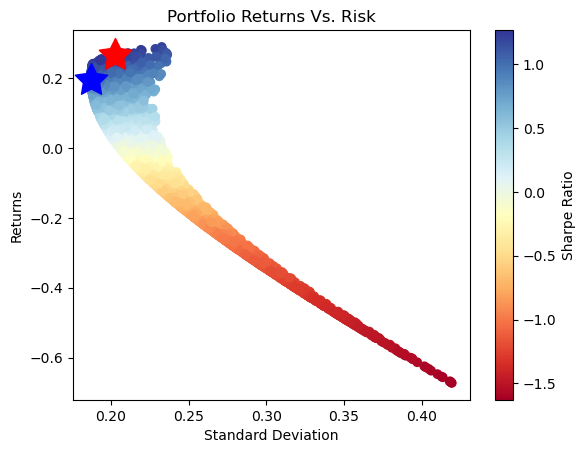

In [24]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

# 6.Optimization with SciPy

In [25]:
def get_metrics(weights: list) -> np.array:

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:

    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    
    return np.sum(weights) - 1

In [26]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2.656025904736669
       x: [ 3.331e-16  5.551e-17  1.000e+00]
     nit: 2
     jac: [ 7.396e-01  8.466e-01 -2.980e-08]
    nfev: 8
    njev: 2
--------------------------------------------------------------------------------


In [27]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[3.33066907e-16 5.55111512e-17 1.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.73471364  0.44366072 -1.6560259 ]
--------------------------------------------------------------------------------
